In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import definitive_dyn_indicators.scripts.data_manager as dm
import os
from tqdm.auto import tqdm
from numba import njit
import lmfit
import joblib
from joblib import Parallel, delayed

In [2]:
njobs = os.cpu_count()

In [3]:
njobs

20

# 0 - General setup

Remote Dir

In [ ]:
data = dm.data_manager(
    data_dir="/eos/project/d/da-and-diffusion-studies/DA_Studies/Simulations/Models/dynamic_indicator_analysis/big_data")

Local Dir

In [4]:
data = dm.data_manager()

Setup config and get times

In [5]:
config = data.get_config()
print(list(config.keys()))
extents = config["x_extents"] + config["y_extents"]
samples = config["samples"]
print(samples)

['name', 'samples', 'random_seed', 'displacement_scale', 'x_extents', 'y_extents', 'low_tracking', 'tracking', 'extreme_tracking', 't_base_10', 't_base_2', 't_linear', 't_base', 'barrier', 't_list', 't_diff', 'x_sample', 'dx', 'y_sample', 'dy', 'xx', 'yy', 'x_flat', 'y_flat', 'px_flat', 'py_flat', 'total_samples', 'displacement', 'x_random_displacement', 'y_random_displacement', 'px_random_displacement', 'py_random_displacement', 'x_displacement', 'y_displacement', 'px_displacement', 'py_displacement']
100


In [66]:
times = np.asarray(data.get_times())
all_times = times.copy()
low_times = times[times <= 1000]
high_times = times[times >= 1000]
good_times = np.unique(np.concatenate([config["t_base_10"], config["t_base_2"], config["t_linear"]]))
#########################
good_times = times.copy()
#########################
print(times)
print(len(times))

[      1       2       3 ...  999000 1000000 1048576]
2037


In [7]:
len(low_times)

1000

### Loading up specific group of datasets

In [8]:
group = (0.168, 0.201, 'sps', 16.0, -0.01, np.nan, np.nan)
group_name = f"$\\epsilon={group[3]}, \\mu={group[4]}$"

In [9]:
group_rand = (0.168, 0.201, 'sps', 16.0, -0.01, 1e-6, np.nan)

In [9]:
group = data.get_groups()[0]
print(group)

group_name = f"$\\epsilon={group[3]}, \\mu={group[4]}$"
print(group_name)

(0.168, 0.201, 'sps', 16.0, -0.01, nan, nan)
$\epsilon=16.0, \mu=-0.01$


### Visualizing the sample

In [12]:
stability = data.stability(group)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking track!


In [67]:
lyapunov = data.fast_lyapunov_indicator(group, times=good_times)
lyapunov_low = data.fast_lyapunov_indicator(group, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement random and tracking step_track!


100%|██████████| 2037/2037 [00:22<00:00, 91.66it/s] 


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement random and tracking step_track!


100%|██████████| 1000/1000 [00:02<00:00, 368.63it/s]


In [68]:
raw_displacement = data.raw_displacement(group, times=good_times)
raw_displacement_low = data.raw_displacement(group, times=low_times) 

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement random and tracking step_track!


100%|██████████| 2037/2037 [00:05<00:00, 387.08it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement random and tracking step_track!


100%|██████████| 1000/1000 [00:02<00:00, 410.56it/s]


In [69]:
lyapunov_multi = data.invariant_lyapunov_indicator(group, times=good_times)
lyapunov_multi_low = data.invariant_lyapunov_indicator(group, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement x and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement px and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement y and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement py and tracking step_track!


100%|██████████| 2037/2037 [00:50<00:00, 40.68it/s] 


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement x and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement px and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement y and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement py and tracking step_track!


100%|██████████| 1000/1000 [00:06<00:00, 145.17it/s]


In [70]:
reverse = data.reversibility_error(group, times=good_times)
reverse_low = data.reversibility_error(group, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking track_and_reverse!


100%|██████████| 2037/2037 [00:12<00:00, 160.80it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking track_and_reverse!


100%|██████████| 1000/1000 [00:01<00:00, 685.84it/s]


In [71]:
reverse_rand = data.reversibility_error(group_rand, times=good_times)
reverse_rand_low = data.reversibility_error(group_rand, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, 1e-06, nan) with displacement none and tracking track_and_reverse!


100%|██████████| 2037/2037 [00:10<00:00, 192.23it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, 1e-06, nan) with displacement none and tracking track_and_reverse!


100%|██████████| 1000/1000 [00:01<00:00, 622.63it/s]


In [72]:
megno = data.megno(group, times=good_times)
megno_low = data.megno(group, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking megno!


100%|██████████| 2037/2037 [00:00<00:00, 2781.29it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking megno!


100%|██████████| 1000/1000 [00:00<00:00, 2863.28it/s]


In [73]:
sali = data.smallest_alignment_index(group, times=good_times)
sali_low = data.smallest_alignment_index(group, times=low_times)
gali = data.global_alignment_index(group, times=good_times)
gali_low = data.global_alignment_index(group, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement x and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement y and tracking step_track!


100%|██████████| 2037/2037 [00:08<00:00, 242.84it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement x and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement y and tracking step_track!


100%|██████████| 1000/1000 [00:04<00:00, 226.36it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement x and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement y and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement px and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement py and tracking step_track!


100%|██████████| 2037/2037 [00:58<00:00, 34.79it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement x and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement y and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement px and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement py and tracking step_track!


100%|██████████| 1000/1000 [00:32<00:00, 31.21it/s]


In [74]:
radius = data.initial_radius()

 ### Execute this cell if you want to perform the downsampling

In [10]:
ds_step = 5

In [19]:
raw_displacement = dm.apply_downsample_to_dataset(raw_displacement, step=ds_step)
megno = dm.apply_downsample_to_dataset(megno, step=ds_step)
sali = dm.apply_downsample_to_dataset(sali, step=ds_step)
gali = dm.apply_downsample_to_dataset(gali, step=ds_step)


100%|██████████| 71/71 [00:00<00:00, 2793.58it/s]


In [18]:
reverse = dm.apply_downsample_to_dataset(reverse, step=ds_step)

100%|██████████| 71/71 [00:00<00:00, 1501.58it/s]


In [13]:
radius = dm.downsample(radius, step=ds_step)

In [14]:
stability = dm.downsample(stability, step=ds_step)
lyapunov = dm.apply_downsample_to_dataset(lyapunov, step=ds_step)

100%|██████████| 71/71 [00:00<00:00, 1671.26it/s]


In [15]:
extents = config["x_extents"] + config["y_extents"]
samples = config["samples"]//ds_step
print(samples)

200


### visualising the sample

/tmp/ipykernel_24459/2419872090.py:28: RuntimeWarning: divide by zero encountered in log10
  np.log10(reverse[val].to_numpy()).reshape(samples, samples),


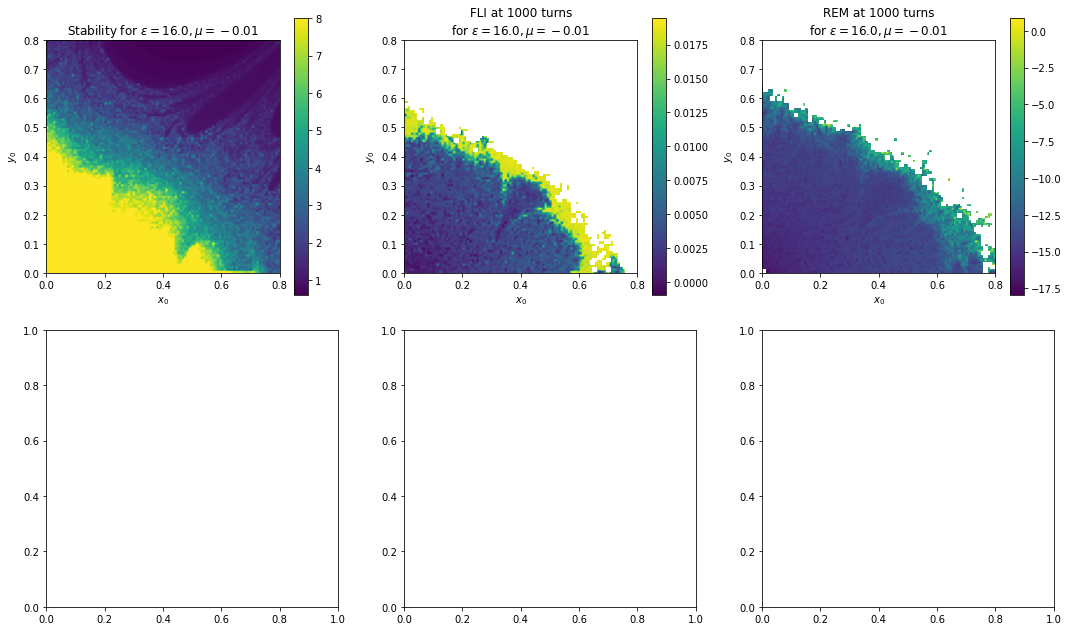

In [18]:
val = 1000

fig, axs = plt.subplots(2, 3, figsize=(15, 9))

im_00 = axs[0][0].imshow(
    np.log10(stability.reshape(samples, samples)),
    origin="lower",
    extent=extents,
)
# set colorbar for im_00
fig.colorbar(im_00, ax=axs[0][0])
axs[0][0].set_title(f"Stability for {group_name}")
axs[0][0].set_xlabel("$x_0$")
axs[0][0].set_ylabel("$y_0$")

im_01 = axs[0][1].imshow(
    lyapunov[val].to_numpy().reshape(samples, samples),
    origin="lower",
    extent=extents,
)
# set colorbar for im_01
fig.colorbar(im_01, ax=axs[0][1])
axs[0][1].set_title(f"FLI at {val} turns\nfor {group_name}")
axs[0][1].set_xlabel("$x_0$")
axs[0][1].set_ylabel("$y_0$")

im_02 = axs[0][2].imshow(
    np.log10(reverse[val].to_numpy()).reshape(samples, samples),
    origin="lower",
    extent=extents,
)
# set colorbar for im_02
fig.colorbar(im_02, ax=axs[0][2])
axs[0][2].set_title(f"REM at {val} turns\nfor {group_name}")
axs[0][2].set_xlabel("$x_0$")
axs[0][2].set_ylabel("$y_0$")

# im_10 = axs[1][0].imshow(
#     megno[val].to_numpy().reshape(samples, samples),
#     origin="lower",
#     extent=extents,
# )
# # set colorbar for im_10
# fig.colorbar(im_10, ax=axs[1][0])
# axs[1][0].set_title(f"MEGNO at {val} turns\nfor {group_name}")
# axs[1][0].set_xlabel("$x_0$")
# axs[1][0].set_ylabel("$y_0$")

# im_11 = axs[1][1].imshow(
#     np.log10(sali[val].to_numpy()).reshape(samples, samples),
#     origin="lower",
#     extent=extents,
# )
# # set colorbar for im_11
# fig.colorbar(im_11, ax=axs[1][1])
# axs[1][1].set_title(f"SALI at {val} turns\nfor {group_name}")
# axs[1][1].set_xlabel("$x_0$")
# axs[1][1].set_ylabel("$y_0$")

# im_12 = axs[1][2].imshow(
#     np.log10(gali[val].to_numpy()).reshape(samples, samples),
#     origin="lower",
#     extent=extents,
# )
# # set colorbar for im_12
# fig.colorbar(im_12, ax=axs[1][2])
# axs[1][2].set_title(f"GALI at {val} turns\nfor {group_name}")
# axs[1][2].set_xlabel("$x_0$")
# axs[1][2].set_ylabel("$y_0$")

plt.tight_layout()

# 1 - Chaos analysis

## 1.0 - Defining a "Golden Standard" for Chaos measurement

We recall the formula for the Fast Lyapunov Indicator computed after $n$ iterations of the map $M$:

$$
FLI_n(\mathbf{x}_0) = \frac{\ln\frac{|M^n(\mathbf{x}) - M^n(\mathbf{x} + \epsilon \mathbf{\hat{e}})|}{\epsilon}}{n}
$$

Let's consider two iteration times $n_1 = 10^3$ and $n_2 = 10^5$ and the corresponding values obtained by FLI

In [25]:
t1 = 100
t2 = 100000

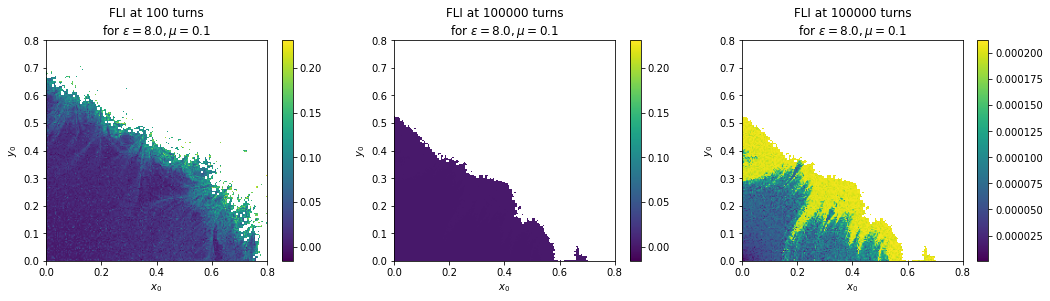

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

im_0 = axs[0].imshow(
    lyapunov[t1].to_numpy().reshape(samples, samples),
    origin="lower",
    extent=extents,
)
# set colorbar for im_0
fig.colorbar(im_0, ax=axs[0])
axs[0].set_title(f"FLI at {t1} turns\nfor {group_name}")
axs[0].set_xlabel("$x_0$")
axs[0].set_ylabel("$y_0$")

# use the same colorbar for im_1
im_1 = axs[1].imshow(
    lyapunov[t2].to_numpy().reshape(samples, samples),
    origin="lower",
    extent=extents,
    vmin=im_0.get_clim()[0],
    vmax=im_0.get_clim()[1],
)
# set colorbar for im_1
fig.colorbar(im_1, ax=axs[1])
axs[1].set_title(f"FLI at {t2} turns\nfor {group_name}")
axs[1].set_xlabel("$x_0$")
axs[1].set_ylabel("$y_0$")


im_1 = axs[2].imshow(
    lyapunov[t2].to_numpy().reshape(samples, samples),
    origin="lower",
    extent=extents,
)
# set colorbar for im_1
fig.colorbar(im_1, ax=axs[2])
axs[2].set_title(f"FLI at {t2} turns\nfor {group_name}")
axs[2].set_xlabel("$x_0$")
axs[2].set_ylabel("$y_0$")

plt.tight_layout()


We do observe a strong decrease in the FLI values, this is related to the distance boundaries given by the Hénon map: having a finite region for stable motion of radius $r$, a copule of particles can either

1. Maintain a displacement distance $< r$, which will lead FLI to zero as $n \to \infty$
2. Go $> r$ with the displacement, and eventually get lost in the chaotic region of the map.

Let's take as an estimation that $r = 1.0$ and let's visualize the resulting boundary along with the time evolution of FLI

In [158]:
@njit
def log_fit(x, a, k):
    return -k * np.log10(x) + a

def residual_log_fit(params, x, y):
    a = (params["a"].value)
    k = params["k"].value

    model = log_fit(x, a, k)
    return model - np.log10(y)

In [160]:
def fit(x, y, s, i, kind="scale_law", extra_log=False):
    # print(i)
    try:
        if extra_log:
            y = np.log10(y)
        # x = (x[np.logical_and(np.logical_not(np.isnan(y)), y > 0)])
        # y = (y[np.logical_and(np.logical_not(np.isnan(y)), y > 0)])
        x = np.absolute((x[np.logical_not(np.isnan(y))]))
        y = np.absolute((y[np.logical_not(np.isnan(y))]))
        # y = y[x>100]
        # x = x[x>100]
        if len(x[x>100]) < 2:
            return "discarded"

#        f = scipy.interpolate.interp1d(x, y, kind="linear")
#        x = np.unique(np.sort(np.concatenate((np.asarray(x, dtype=float), np.linspace(x[0], x[-1], 2000)))))
#        y = f(x)

        params = lmfit.Parameters()
        if kind=="log_fit":
            params.add("a", value=0)
            params.add("k", value=1)
            result = lmfit.minimize(
                residual_log_fit, params, args=(x, y), method="least_squares")
        else:
            raise ValueError(f"kind {kind} not recognized")
        return result
    except ValueError:
        # print(e)
        return "error"


In [162]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        lyapunov.iterrows(),
        stability
    ))
)

par_lyap_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyap_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyap_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [163]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        lyapunov_low.iterrows(),
        stability
    ))
)

par_lyap_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyap_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyap_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [164]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        lyapunov_multi.iterrows(),
        stability
    ))
)

par_lyapm_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [165]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        lyapunov_multi_low.iterrows(),
        stability
    ))
)

par_lyapm_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [166]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        reverse.iterrows(),
        stability
    ))
)

par_rev_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_rev_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_rev_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/

In [167]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        reverse_low.iterrows(),
        stability
    ))
)

par_rev_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_rev_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_rev_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/

In [168]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        reverse_rand.iterrows(),
        stability
    ))
)

par_revr_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_revr_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_revr_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [169]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        reverse_rand_low.iterrows(),
        stability
    ))
)

par_revr_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_revr_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_revr_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [170]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        gali.iterrows(),
        stability
    ))
)

par_gali_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_gali_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_gali_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [171]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        gali_low.iterrows(),
        stability
    ))
)

par_gali_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_gali_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_gali_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [172]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        sali.iterrows(),
        stability
    ))
)

par_sali_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_sali_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_sali_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [173]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        sali_low.iterrows(),
        stability
    ))
)

par_sali_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_sali_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_sali_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [174]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        megno.iterrows(),
        stability
    ))
)

par_megno_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_megno_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_megno_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/

In [175]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        megno_low.iterrows(),
        stability
    ))
)

par_megno_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_megno_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_megno_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/33867537.py:10: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_27961/

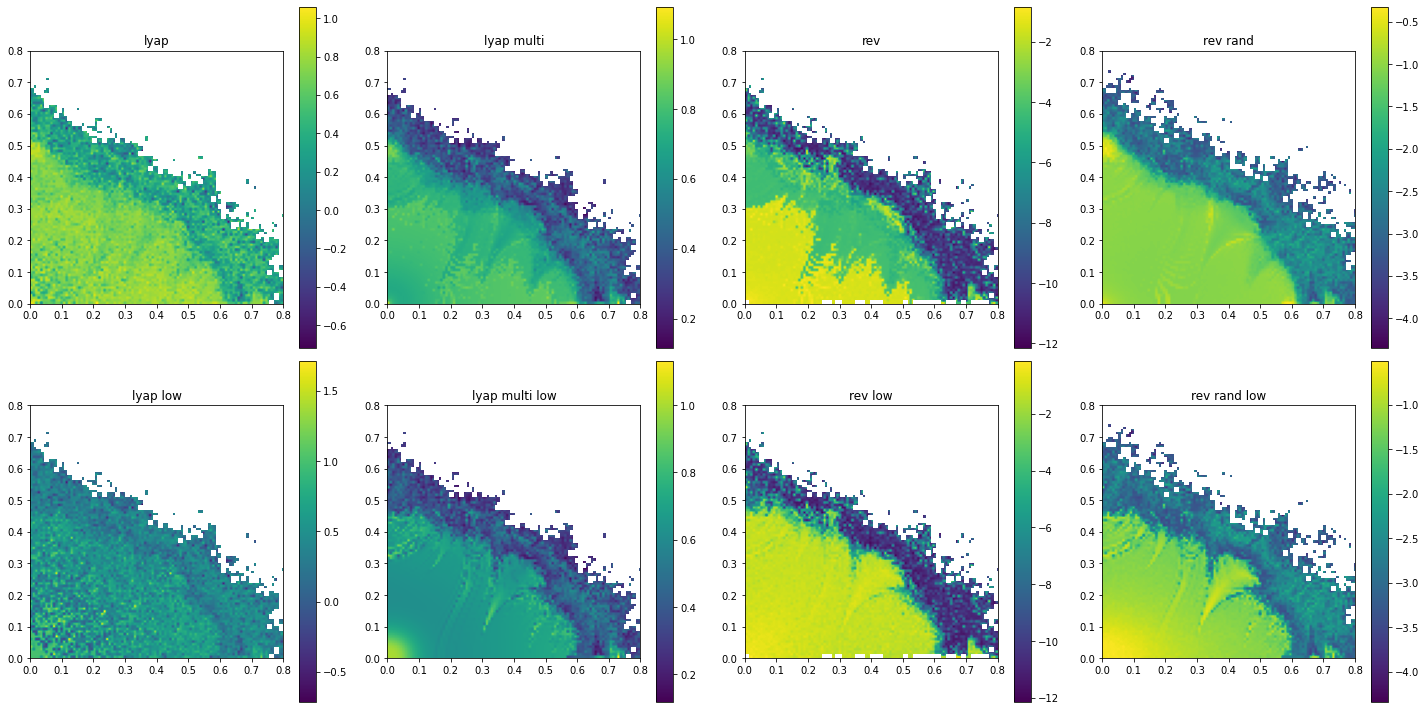

In [176]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

map = axs[0][0].imshow(par_lyap_k.reshape(samples, samples),
                    origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][0])
axs[0][0].set_title("lyap")

map = axs[1][0].imshow(par_lyap_low_k.reshape(samples, samples),
                    origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][0])
axs[1][0].set_title("lyap low")


map = axs[0][1].imshow(par_lyapm_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][1])
axs[0][1].set_title("lyap multi")

map = axs[1][1].imshow(par_lyapm_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][1])
axs[1][1].set_title("lyap multi low")


map = axs[0][2].imshow(par_rev_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][2])
axs[0][2].set_title("rev")

map = axs[1][2].imshow(par_rev_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][2])
axs[1][2].set_title("rev low")


map = axs[0][3].imshow(par_revr_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][3])
axs[0][3].set_title("rev rand")

map = axs[1][3].imshow(par_revr_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][3])
axs[1][3].set_title("rev rand low")


plt.tight_layout()


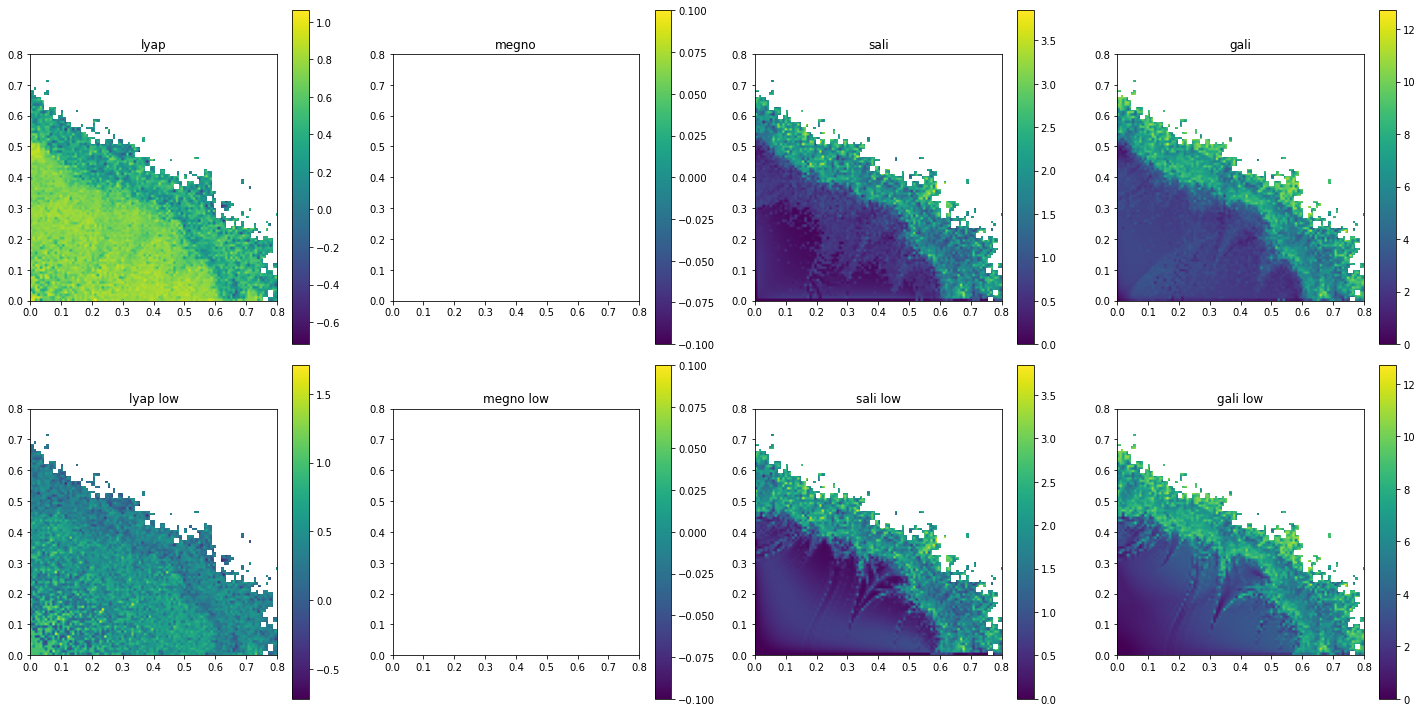

In [177]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

map = axs[0][0].imshow(par_lyap_k.reshape(samples, samples),
                    origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][0])
axs[0][0].set_title("lyap")

map = axs[1][0].imshow(par_lyap_low_k.reshape(samples, samples),
                    origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][0])
axs[1][0].set_title("lyap low")


map = axs[0][1].imshow(par_megno_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][1])
axs[0][1].set_title("megno")

map = axs[1][1].imshow(par_megno_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][1])
axs[1][1].set_title("megno low")


map = axs[0][2].imshow(par_sali_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][2])
axs[0][2].set_title("sali")

map = axs[1][2].imshow(par_sali_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][2])
axs[1][2].set_title("sali low")


map = axs[0][3].imshow(par_gali_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][3])
axs[0][3].set_title("gali")

map = axs[1][3].imshow(par_gali_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][3])
axs[1][3].set_title("gali low")


plt.tight_layout()


idx: 5241
a: 138.79016694671913, k: 5.920617879325637


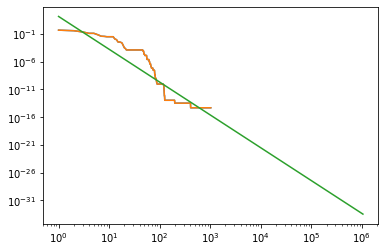

In [121]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]
print(f"idx: {idx}")

plt.plot(
    gali.iloc[idx].index.to_numpy(),
    gali.iloc[idx].to_numpy()
)

plt.plot(
    gali.iloc[idx].index.to_numpy(),
    gali.iloc[idx].to_numpy()
)

plt.plot(
    gali.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        gali.iloc[idx].index.to_numpy(),
        par_gali_a[idx], par_gali_k[idx]
    ))
)

print(f"a: {par_gali_a[idx]}, k: {par_gali_k[idx]}")

plt.xscale("log")
plt.yscale("log")

idx: 4633
a: 2.152870501648252e-06, k: -1.1173042065156147


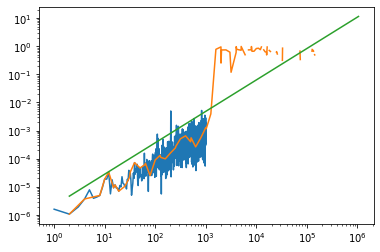

In [49]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]
print(f"idx: {idx}")

plt.plot(
    reverse_rand_low.iloc[idx].index.to_numpy(),
    reverse_rand_low.iloc[idx].to_numpy()
)

plt.plot(
    reverse_rand.iloc[idx].index.to_numpy(),
    reverse_rand.iloc[idx].to_numpy()
)

plt.plot(
    reverse_rand.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        reverse_rand.iloc[idx].index.to_numpy(),
        par_revr_a[idx], par_revr_k[idx]
    ))
)

print(f"a: {par_revr_a[idx]}, k: {par_revr_k[idx]}")

plt.xscale("log")
plt.yscale("log")

idx: 243
a: -18.353432885011596, k: -1.577887795070826


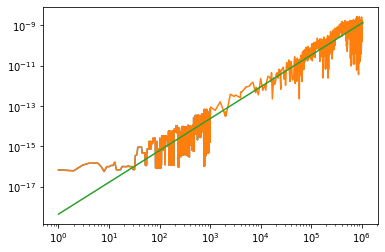

In [178]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]

idx = 243
print(f"idx: {idx}")

plt.plot(
    reverse_low.iloc[idx].index.to_numpy(),
    reverse_low.iloc[idx].to_numpy()
)

plt.plot(
    reverse.iloc[idx].index.to_numpy(),
    reverse.iloc[idx].to_numpy()
)

plt.plot(
    reverse.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        reverse.iloc[idx].index.to_numpy(),
        par_rev_a[idx], par_rev_k[idx]
    ))
)


print(f"a: {par_rev_a[idx]}, k: {par_rev_k[idx]}")

plt.xscale("log")
plt.yscale("log")

idx: 3250
ALL -> a: 0.5942281247044405, k: 0.7147823531408283
LOW -> a: 0.2687676716597116, k: 0.6307803384346089


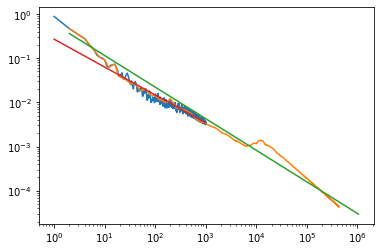

In [57]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]
print(f"idx: {idx}")

plt.plot(
    lyapunov_multi_low.iloc[idx].index.to_numpy(),
    lyapunov_multi_low.iloc[idx].to_numpy()
)

plt.plot(
    lyapunov_multi.iloc[idx].index.to_numpy(),
    lyapunov_multi.iloc[idx].to_numpy()
)

plt.plot(
    lyapunov_multi.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        lyapunov_multi.iloc[idx].index.to_numpy(),
        par_lyapm_a[idx], par_lyapm_k[idx]
    ))
)

plt.plot(
    lyapunov_multi_low.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        lyapunov_multi_low.iloc[idx].index.to_numpy(),
        par_lyapm_low_a[idx], par_lyapm_low_k[idx]
    ))
)

print(f"ALL -> a: {par_lyapm_a[idx]}, k: {par_lyapm_k[idx]}")
print(f"LOW -> a: {par_lyapm_low_a[idx]}, k: {par_lyapm_low_k[idx]}")

plt.xscale("log")
plt.yscale("log")

idx: 2552
ALL -> a: 0.012296181837745168, k: -0.19293626101642516
LOW -> a: 0.012296181837745168, k: -0.19293626101642516


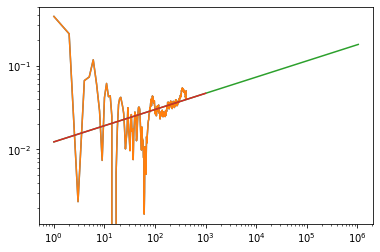

In [94]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]
print(f"idx: {idx}")

idx = 6409

plt.plot(
    lyapunov_low.iloc[idx].index.to_numpy(),
    lyapunov_low.iloc[idx].to_numpy()
)

plt.plot(
    lyapunov.iloc[idx].index.to_numpy(),
    lyapunov.iloc[idx].to_numpy()
)

plt.plot(
    lyapunov.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        lyapunov.iloc[idx].index.to_numpy(),
        par_lyap_a[idx], par_lyap_k[idx]
    ))
)

plt.plot(
    lyapunov_low.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        lyapunov_low.iloc[idx].index.to_numpy(),
        par_lyap_low_a[idx], par_lyap_low_k[idx]
    ))
)

print(f"ALL -> a: {par_lyap_a[idx]}, k: {par_lyap_k[idx]}")
print(f"LOW -> a: {par_lyap_low_a[idx]}, k: {par_lyap_low_k[idx]}")

plt.xscale("log")
plt.yscale("log")

idx: 1048
ALL -> a: nan, k: nan
LOW -> a: nan, k: nan


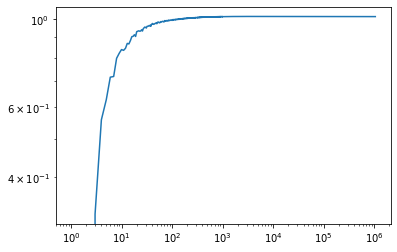

In [111]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]
print(f"idx: {idx}")

#idx = 6409

# plt.plot(
#     megno_low.iloc[idx].index.to_numpy(),
#     megno_low.iloc[idx].to_numpy()
# )

plt.plot(
    megno.iloc[idx].index.to_numpy(),
    megno.iloc[idx].to_numpy()
)

plt.plot(
    megno.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        megno.iloc[idx].index.to_numpy(),
        par_megno_a[idx], par_megno_k[idx]
    ))
)

plt.plot(
    megno_low.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        megno_low.iloc[idx].index.to_numpy(),
        par_megno_low_a[idx], par_megno_low_k[idx]
    ))
)

print(f"ALL -> a: {par_megno_a[idx]}, k: {par_megno_k[idx]}")
print(f"LOW -> a: {par_megno_low_a[idx]}, k: {par_megno_low_k[idx]}")

plt.xscale("log")
plt.yscale("log")

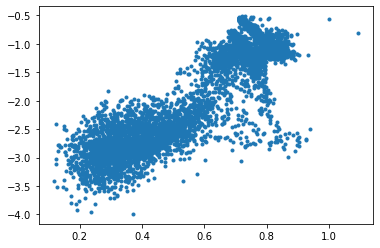

In [126]:
plt.plot(
    par_lyapm_k,
    par_revr_low_k,
    "."
)

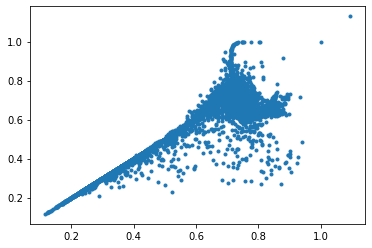

In [125]:
plt.plot(
    par_lyapm_k,
    par_lyapm_low_k,
    "."
)

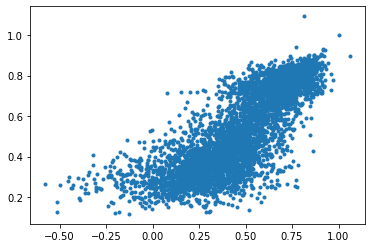

In [124]:
plt.plot(
    par_lyap_k,
    par_lyapm_k,
    "."
)

## 1.1 - Direct comparisons and correlations with the various Dynamic indicators

### 1.1.0 - Colors!

In [18]:
# Make the base colors
colors_stability = dm.colorize(stability, log10=True)
colors_radius = dm.colorize(data.initial_radius(), vmax=0.7)
colors_rad_stab = dm.colorize(stability, log10=True)

In [19]:
# Mask considering radius
radius_color = 0.3

before_mask = data.initial_radius() <= radius_color
after_mask = data.initial_radius() > radius_color

In [20]:
colors_rad_stab[before_mask] = dm.colorize(
    stability[before_mask], log10=True, cmap="cool")
colors_rad_stab[after_mask] = dm.colorize(
    stability[after_mask], log10=True, cmap="Wistia")

### 1.1.1 - Invariant Lyapunov

Text(0, 0.5, 'Invariant Lyapunov Indicator at 1000')

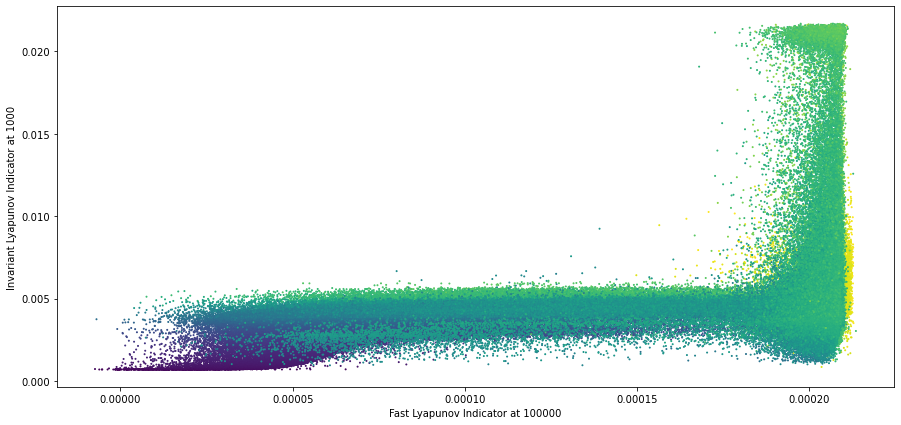

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov[t2].to_numpy(),
    lyapunov_multi[t1].to_numpy(),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Fast Lyapunov Indicator at {t2}")
ax.set_ylabel(f"Invariant Lyapunov Indicator at {t1}")

### 1.1.2 - Reversibility error

/tmp/ipykernel_8039/3124219978.py:5: RuntimeWarning: divide by zero encountered in log10
  np.log10(reverse[t1].to_numpy()),


Text(0, 0.5, 'Reversibility Indicator at 1000')

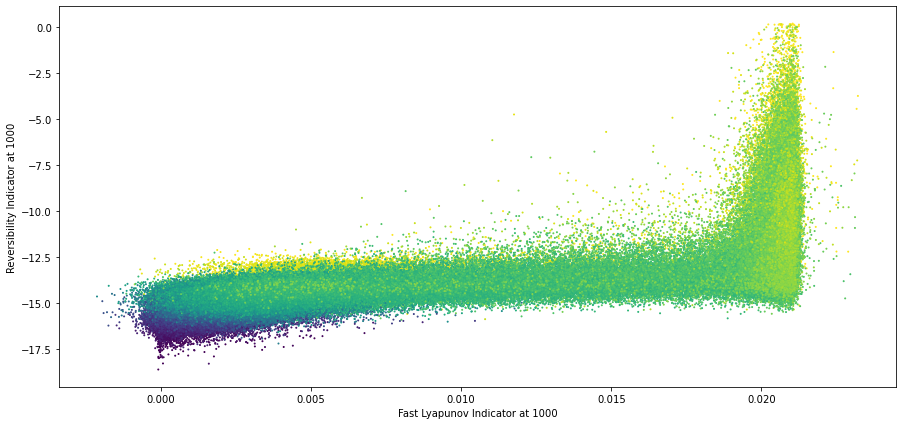

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov[t1].to_numpy(),
    np.log10(reverse[t1].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Fast Lyapunov Indicator at {t1}")
ax.set_ylabel(f"Reversibility Indicator at {t1}")


### 1.1.3 - SALI and GALI

Text(0, 0.5, 'SALI at 1000')

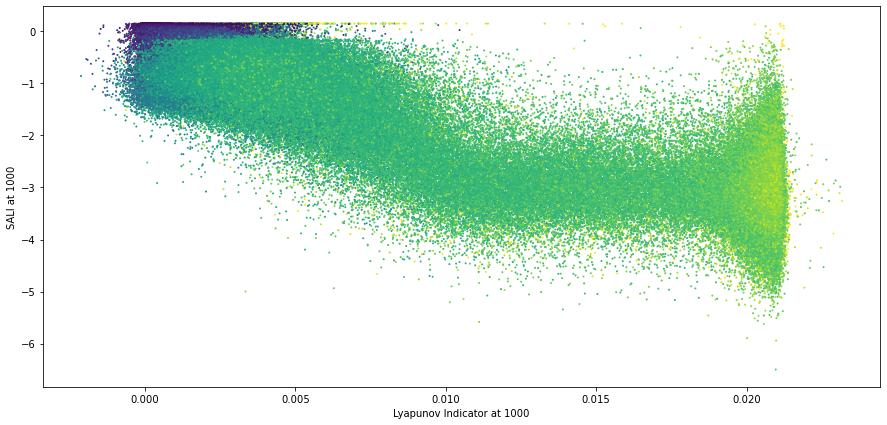

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov[t1].to_numpy(),
    np.log10(sali[t1].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Lyapunov Indicator at {t1}")
ax.set_ylabel(f"SALI at {t1}")


Text(0, 0.5, 'GALI at 1000')

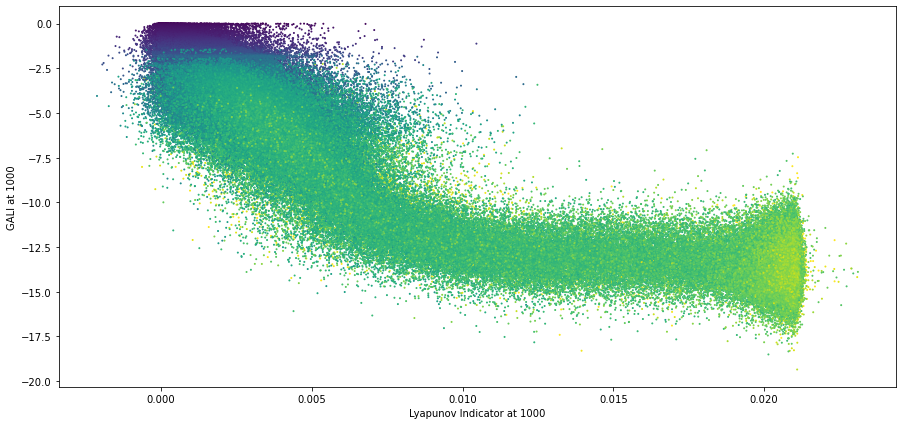

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov[t1].to_numpy(),
    np.log10(gali[t1].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Lyapunov Indicator at {t1}")
ax.set_ylabel(f"GALI at {t1}")

### 1.1.4 - MEGNO

Text(0, 0.5, 'MEGNO at 100000')

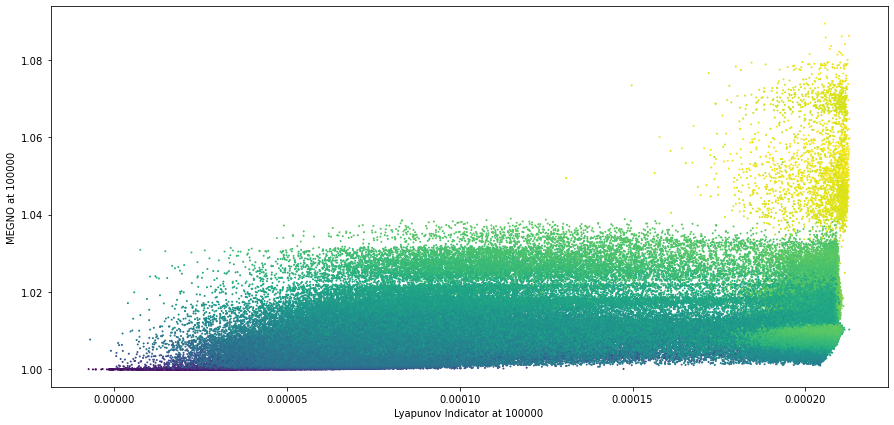

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov[t2].to_numpy(),
    (megno[t2].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Lyapunov Indicator at {t2}")
ax.set_ylabel(f"MEGNO at {t2}")

## 1.2 - Visualizing convergence for the various Dynamic indicators

Text(0, 0.5, 'Lyapunov Indicator at 100000')

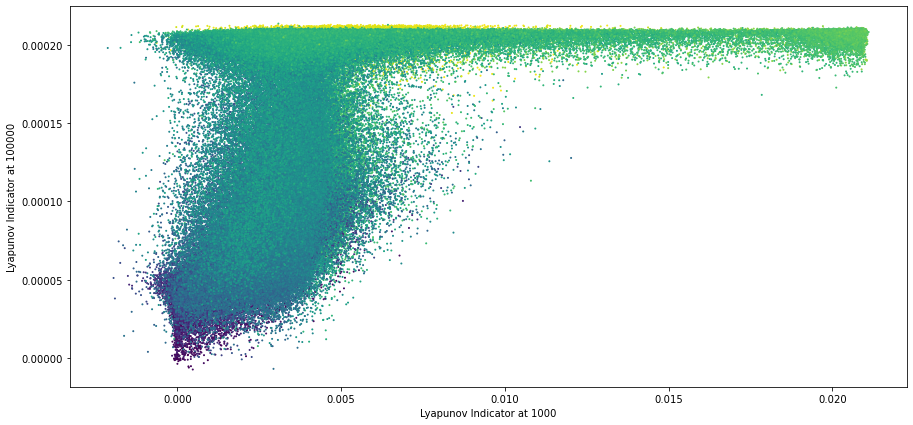

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov[t1].to_numpy(),
    lyapunov[t2].to_numpy(),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Lyapunov Indicator at {t1}")
ax.set_ylabel(f"Lyapunov Indicator at {t2}")

Text(0, 0.5, 'Lyapunov Indicator at 100000')

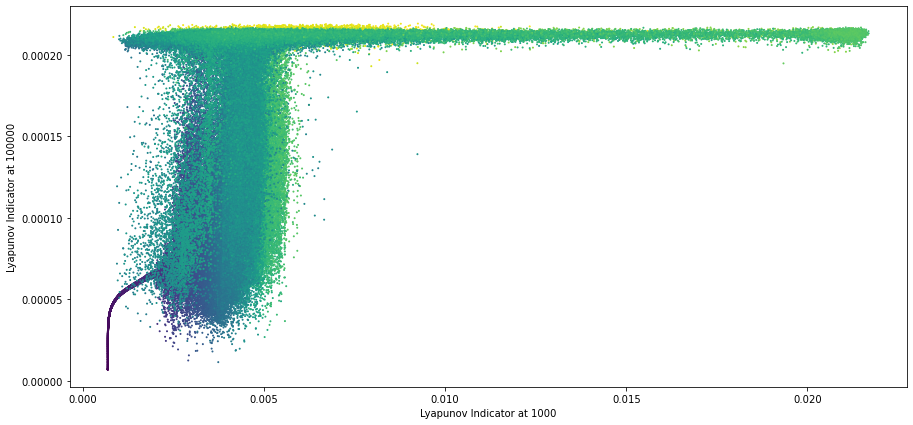

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov_multi[t1].to_numpy(),
    lyapunov_multi[t2].to_numpy(),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Lyapunov Indicator at {t1}")
ax.set_ylabel(f"Lyapunov Indicator at {t2}")

/tmp/ipykernel_25866/3792515338.py:4: RuntimeWarning: divide by zero encountered in log10
  np.log10(reverse[t1].to_numpy()),
/tmp/ipykernel_25866/3792515338.py:5: RuntimeWarning: divide by zero encountered in log10
  np.log10(reverse[t2].to_numpy()),


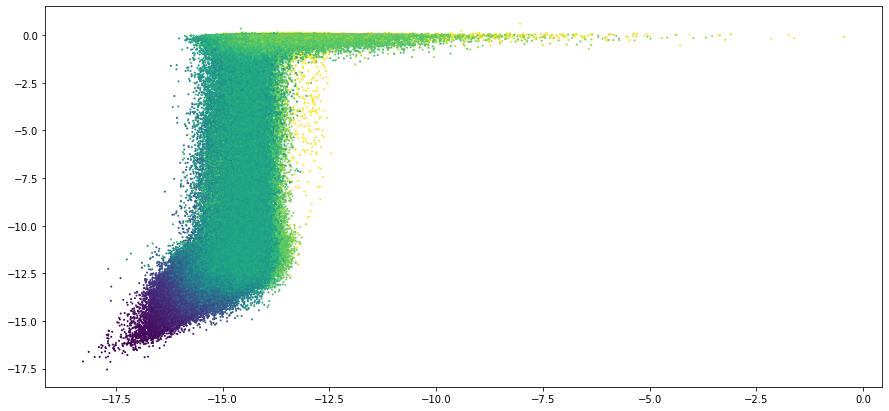

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    np.log10(reverse[t1].to_numpy()),
    np.log10(reverse[t2].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Reversibility Indicator at {t1}")
ax.set_ylabel(f"Reversibility Indicator at {t2}")


Text(0, 0.5, 'SALI at 100000')

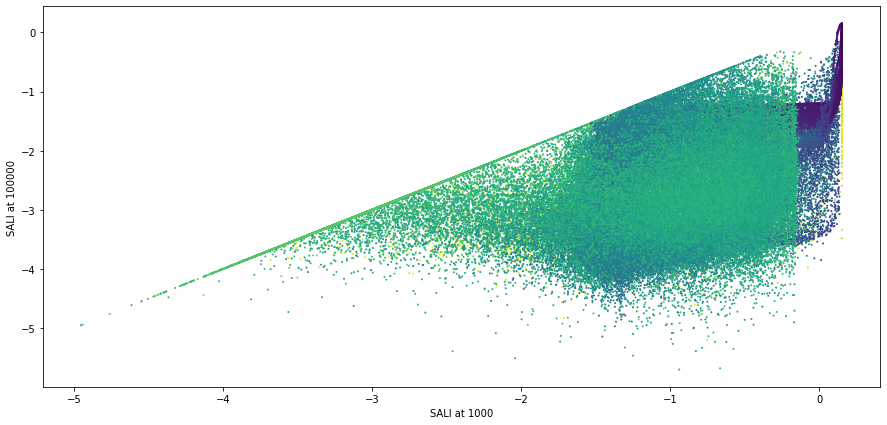

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    np.log10(sali[t1].to_numpy()),
    np.log10(sali[t2].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"SALI at {t1}")
ax.set_ylabel(f"SALI at {t2}")

Text(0, 0.5, 'GALI at 100000')

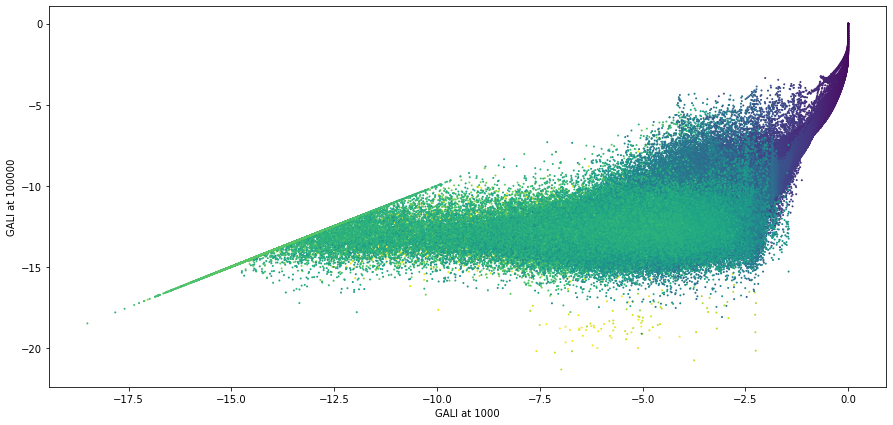

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    np.log10(gali[t1].to_numpy()),
    np.log10(gali[t2].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"GALI at {t1}")
ax.set_ylabel(f"GALI at {t2}")

## 1.3 - Marking down the line and operating with the classification: how to get the best accuracy?

In [41]:
dm.classify_with_data(lyapunov[t1], np.log10(reverse[t1]), 0.015, -10, stable_if_higher=True)

{'tp': 26325,
 'fp': 81318,
 'fn': 32,
 'tn': 328358,
 'total': 436033,
 'accuracy': 0.8134315521990308,
 'precision': 0.2445584013823472,
 'recall': 0.9987859012785977}

## 1.4 - What happens if we perform an averaging convolution?

In [103]:
lyapunov_convolve = dm.apply_convolution_to_dataset(lyapunov, 4)[0]
lyapunov_multi_convolve = dm.apply_convolution_to_dataset(lyapunov_multi, 4)[0]
reverse_convolve = dm.apply_convolution_to_dataset(reverse, 4)[0]
sali_convolve = dm.apply_convolution_to_dataset(sali, 4)[0]
gali_convolve = dm.apply_convolution_to_dataset(gali, 4)[0]
megno_convolve = dm.apply_convolution_to_dataset(megno, 4)[0]


100%|██████████| 71/71 [00:06<00:00, 10.63it/s]


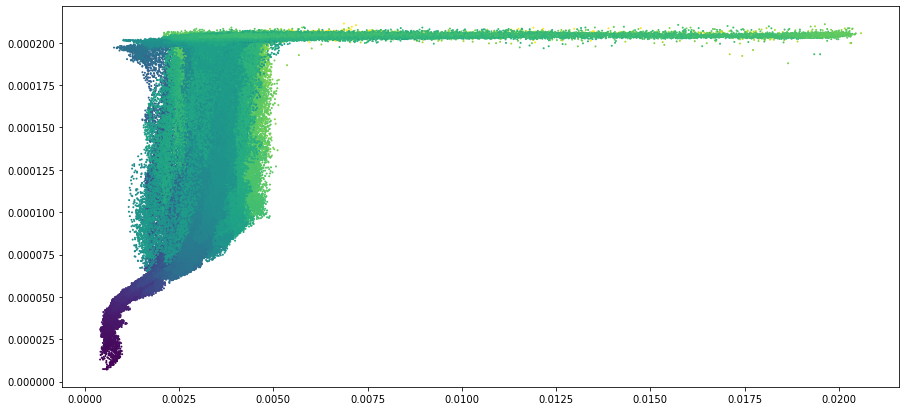

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov_convolve[t1].to_numpy(),
    lyapunov_convolve[t2].to_numpy(),
    s=1,
    c=colors_radius,
)
